#### This notebook finds out embeddings and use it to create the Machine Learning Models

## Imports

In [1]:
import pandas as pd
import pickle
from pandarallel import pandarallel
from scipy import stats
import time
import numpy as np
from sklearn.utils import shuffle


In [2]:
## Load the pre-created Diag_med key sert
with open('/home/pprusty/data_science/Project/pandas_impl/BalancedResult/diag_med_key_set.pickle','rb') as fh:
    diag_med_key_set = pickle.load(fh)

In [3]:
len(diag_med_key_set)

17359

In [4]:
## Load the balanced afib 100 dataset
df = pd.read_pickle('/home/pprusty/data_science/Project/pandas_impl/BalancedResult/balanced_afib_100.pickle')

In [5]:
df.shape

(45996, 3)

In [6]:
## Create an NP Array of zeros
input_np_array = np.zeros((45996 , 17359)).astype(int)

In [8]:
## Create a map of key name and its column in NP Array
key_name_column_id_dict = {}
column = 0
for key in diag_med_key_set:
    key_name_column_id_dict[key] = column
    column = column + 1

In [9]:
## Fill the input np array
input_np_array = np.zeros((45996 , 17359)).astype(int)
for index, row in df.iterrows():
    # Get the list of diag_med values for each patient
    list_ids = row['diag_med'].split(',')
    # We want only unique values, not count multiple times for one patient
    list_id_set = set(list_ids)
    for key in list_id_set:
        input_np_array[index][key_name_column_id_dict[key]] = 1

In [10]:
input_np_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Create the Autoencoder Model

In [1]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 100  # 

# This is our input image
input_row = keras.Input(shape=(17359,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_row)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(17359, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_row, decoded)

In [13]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_row, encoded)

In [14]:
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [15]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
input_np_array.shape

(45996, 17359)

In [18]:
## Create XTrain
XTrain =  input_np_array[0:22998]

In [19]:
## Create yTrain
yTrain =  input_np_array[22998:]

In [22]:
autoencoder.fit(XTrain, XTrain,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(yTrain, yTrain))

Epoch 1/50
90/90 [==============================] - 20s 226ms/step - loss: 0.3179 - accuracy: 0.0267 - val_loss: 0.1115 - val_accuracy: 0.0287
Epoch 2/50
90/90 [==============================] - 12s 136ms/step - loss: 0.0800 - accuracy: 0.0276 - val_loss: 0.0596 - val_accuracy: 0.0287
Epoch 3/50
90/90 [==============================] - 12s 134ms/step - loss: 0.0485 - accuracy: 0.0276 - val_loss: 0.0404 - val_accuracy: 0.0287
Epoch 4/50
90/90 [==============================] - 12s 134ms/step - loss: 0.0334 - accuracy: 0.0276 - val_loss: 0.0300 - val_accuracy: 0.0287
Epoch 5/50
90/90 [==============================] - 12s 133ms/step - loss: 0.0252 - accuracy: 0.0276 - val_loss: 0.0241 - val_accuracy: 0.0287
Epoch 6/50
90/90 [==============================] - 12s 131ms/step - loss: 0.0203 - accuracy: 0.0276 - val_loss: 0.0204 - val_accuracy: 0.0287
Epoch 7/50
90/90 [==============================] - 12s 132ms/step - loss: 0.0171 - accuracy: 0.0276 - val_loss: 0.0179 - val_accuracy: 0.0287

In [23]:
X_Train_bar = autoencoder.predict(XTrain)

In [24]:
X_Train_bar

array([[5.2712072e-05, 8.6672451e-05, 4.8034787e-03, ..., 4.4410073e-05,
        1.0896446e-04, 2.5331974e-04],
       [5.8656278e-06, 1.1335866e-05, 3.7321448e-04, ..., 5.3385506e-06,
        6.5666736e-06, 5.1692128e-04],
       [1.0886843e-05, 1.8191684e-05, 2.0486116e-03, ..., 1.6892274e-05,
        3.1197887e-05, 5.2363001e-05],
       ...,
       [8.7902023e-05, 8.1919236e-05, 5.4753423e-03, ..., 6.7659632e-05,
        8.3736588e-05, 2.1392107e-04],
       [7.4370860e-06, 9.2977580e-06, 3.5735077e-01, ..., 6.6750026e-06,
        1.5708376e-05, 2.7961711e-05],
       [6.1974330e-05, 1.5228987e-04, 4.4672120e-01, ..., 1.4190078e-03,
        1.6039610e-04, 7.9780817e-04]], dtype=float32)

In [25]:
## Save the model to be used by the Feature Selection model
autoencoder.save('/home/pprusty/data_science/Project/pandas_impl/BalancedResult/autoencoder.model')

### Plot Accuracy and Loss

In [26]:
from matplotlib import pyplot as plt

In [28]:
from matplotlib import rcParams

In [ ]:
rcParams.update({'figure.autolayout': True})
plt.tight_layout()
plt.plot(autoencoder.history.history['loss'])
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.title('Autoencoder Loss', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.savefig('autoencoder_loss.pdf')
plt.show()

In [ ]:
plt.plot(autoencoder.history.history['accuracy'])
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.title('Autoencoder Accuracy', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
#plt.legend(['train'], loc='upper right')
plt.savefig('autoencoder_accuracy.pdf')
plt.show()

## Create a classifier

In [36]:
from keras.models import Model, load_model
from keras.preprocessing import image

In [37]:
## Load the weights from the Dense Layer
testModel =  Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense').output)

In [38]:
## x stores the embeddings
x = testModel.predict(input_np_array)

In [39]:
## For each patient now a 100 feature vector is generated
x.shape

(45996, 100)

In [40]:
X = x

In [41]:
df.columns

Index(['person_id', 'label', 'diag_med'], dtype='object')

In [42]:
y = df['label']

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
## Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### use the classification model

# KNN

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [46]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [47]:
y_pred = classifier.predict(X_test)

In [48]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[3466 1120]
 [1238 3376]]
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      4586
           1       0.75      0.73      0.74      4614

    accuracy                           0.74      9200
   macro avg       0.74      0.74      0.74      9200
weighted avg       0.74      0.74      0.74      9200



In [49]:
from sklearn.metrics import accuracy_score

In [50]:
accuracy_score(y_test, y_pred)

0.7436956521739131

In [51]:
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [52]:
y_pred = classifier.predict(X_test)

In [53]:
accuracy_score(y_test, y_pred)

0.7316304347826087

### Tune HyperParameters of KNN

In [54]:
lst=[2, 5, 10, 15, 20, 25]
acc_lst=[]
for n_neighbors in lst:
    classifier = KNeighborsClassifier(n_neighbors)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    acc_lst.append(accuracy_score(y_test, y_pred))

In [55]:
acc_lst

[0.6904347826086956,
 0.7436956521739131,
 0.7534782608695653,
 0.7639130434782608,
 0.7613043478260869,
 0.7664130434782609]

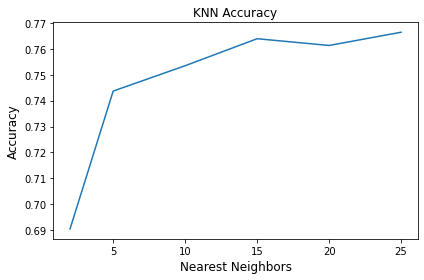

In [56]:
plt.plot(lst,acc_lst)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.title('KNN Accuracy', fontsize=12)
#plt.xticks(lst)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Nearest Neighbors', fontsize=12)
#plt.legend(['train'], loc='upper right')
plt.savefig('knn_accuracy1.pdf')
plt.show()

## Naive Bayes Classifier

In [57]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.6659782608695652

## Decision Tree Classifier

In [58]:
from sklearn import tree

classifier = tree.DecisionTreeClassifier(max_depth=10)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)


0.731304347826087

In [59]:
ls_dtree = [2, 4, 6, 8, 10, 15, 20]
acc_lst_dtree = []
for depth in ls_dtree:
    classifier = tree.DecisionTreeClassifier(max_depth=depth)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    acc_lst_dtree.append(accuracy_score(y_test, y_pred))



In [60]:
acc_lst_dtree

[0.6590217391304348,
 0.7242391304347826,
 0.7359782608695652,
 0.7375,
 0.731304347826087,
 0.7096739130434783,
 0.6880434782608695]

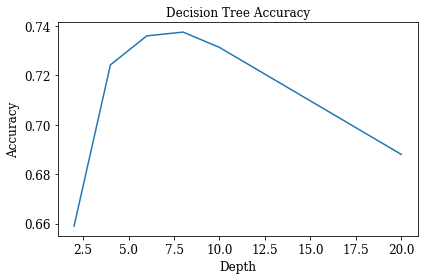

In [61]:
plt.plot(ls_dtree,acc_lst_dtree)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.title('Decision Tree Accuracy', fontsize=12)
#plt.xticks(lst)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Depth', fontsize=12)
#plt.legend(['train'], loc='upper right')
plt.savefig('dt_accuracy1.pdf')
plt.show()

## Compare Classifiers Based on the F1 Score, Precision, Recall and Accuracy

In [79]:
classifier = tree.DecisionTreeClassifier(max_depth=8)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print('F1 Score: ' + str(f1_score(y_test, y_pred)))
print('Precision Score: ' + str(precision_score(y_test, y_pred)))
print('Recall Score: ' + str(recall_score(y_test, y_pred)))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))

F1 Score: 0.7389237086665225
Precision Score: 0.7368534482758621
Recall Score: 0.7410056350238405
Accuracy: 0.7373913043478261


In [80]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print('F1 Score: ' + str(f1_score(y_test, y_pred)))
print('Precision Score: ' + str(precision_score(y_test, y_pred)))
print('Recall Score: ' + str(recall_score(y_test, y_pred)))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))

F1 Score: 0.6122397476340694
Precision Score: 0.7327091513138024
Recall Score: 0.5257910706545297
Accuracy: 0.6659782608695652


In [73]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [64]:
classifier = KNeighborsClassifier(25)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      4586
           1       0.78      0.75      0.76      4614

    accuracy                           0.77      9200
   macro avg       0.77      0.77      0.77      9200
weighted avg       0.77      0.77      0.77      9200



In [78]:
print('F1 Score: ' + str(f1_score(y_test, y_pred)))
print('Precision Score: ' + str(precision_score(y_test, y_pred)))
print('Recall Score: ' + str(recall_score(y_test, y_pred)))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))


F1 Score: 0.7620418558299191
Precision Score: 0.7790355444872085
Recall Score: 0.7457737321196359
Accuracy: 0.7664130434782609
